# Imports

In [75]:
!pip install opendatasets
!pip install pandas-profiling[notebook]
!pip install optuna
!pip install catboost
!pip install opencv-python
!pip install tensorflow
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [76]:
import opendatasets as od
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ProgbarLogger
from skimage.util import random_noise
from skimage.color import rgb2gray
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import ResNet50
import gradio as gr

# Data download

In [15]:
dataset_url = 'https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: izabelamatusiewicz
Your Kaggle Key: ··········


100%|██████████| 14.1M/14.1M [00:00<00:00, 88.5MB/s]

In [16]:
# Path definition
train_path = '/content/alien-vs-predator-images/alien_vs_predator_thumbnails/data/train'
test_path = '/content/alien-vs-predator-images/alien_vs_predator_thumbnails/data/validation'

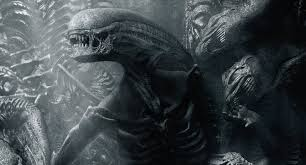

(165, 306, 3)
uint8
0
255


In [17]:
# Sample
img = cv2.imread("/content/alien-vs-predator-images/alien_vs_predator_thumbnails/data/train/alien/10.jpg")
cv2_imshow(img)
print(img.shape)
print(img.dtype)
print(np.min(img))
print(np.max(img))

In [18]:
# Preprocessing pixels -> [0,1]
datagen = ImageDataGenerator(rescale=1./255)

In [19]:
# Reading datasets
test_set = datagen.flow_from_directory(
        test_path,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

train_set = datagen.flow_from_directory(
        train_path,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 200 images belonging to 2 classes.
Found 694 images belonging to 2 classes.


In [20]:
classes_train=os.listdir(train_path)
print(classes_train)

['predator', 'alien']


In [21]:
classes_test=os.listdir(test_path)
print(classes_test)

['predator', 'alien']


# EDA

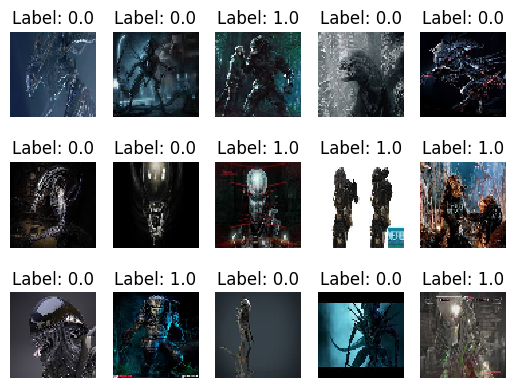

{'alien': 0, 'predator': 1}


In [22]:
# Dowloadig images ad labels
images, labels = train_set.next()

# Wyświetlenie 10 zdjęć wraz z etykietami
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i], interpolation='nearest')
    plt.title('Label: {}'.format(labels[i]))
    plt.axis('off')

plt.show()
print(train_set.class_indices)

In [49]:
# Is dataset balanced?

class_counts = {}

for class_name, class_index in train_set.class_indices.items():
    class_count = len(train_set.labels[train_set.labels == class_index])
    class_counts[class_name] = class_count

print("Pictures count in classes:")
print(class_counts)

Pictures count in classes:
{'alien': 347, 'predator': 347}


# Moddeling with different augumentation techniques

In [51]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

## Black and white augumentation

In [67]:
# Hiperparameters
input_shape = (64, 64, 1)
batch_size = 32
num_classes = 2
epochs = 10

In [53]:
# Change from three channels to one
train_set_bw = train_datagen.flow_from_directory(
    train_path,
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical'
)

test_set_bw = test_datagen.flow_from_directory(
    test_path,
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [54]:
# Checking examplary picture shape
train_set_bw[0][0].shape

(32, 64, 64, 1)

In [55]:
# Basic model building
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Model fitting
history = model.fit(
    train_set_bw,
    steps_per_epoch=train_set_bw.samples//batch_size,
    epochs=epochs,
    validation_data=test_set_bw,
    validation_steps=test_set_bw.samples//batch_size
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 12544)             0         
                                                                 
 dropout_2 (Dropout)         (None, 12544)            

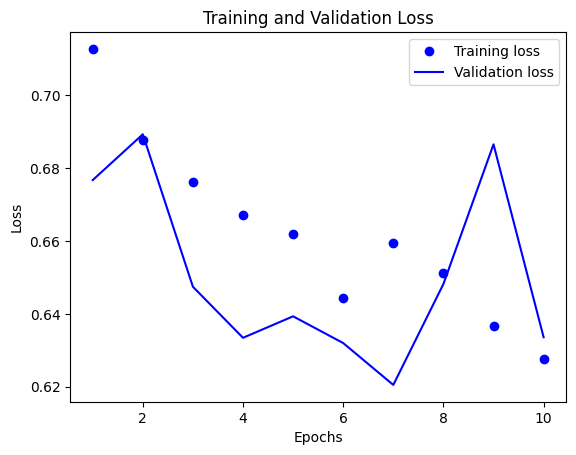

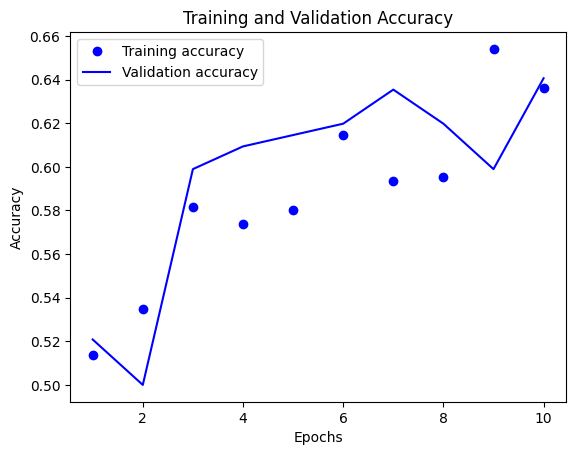

In [56]:
# Learning graph
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Noise augumentation

In [62]:
# Generator with noise
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=random_noise
)

In [63]:
# Reading datasets from directories
train_set_noise = datagen.flow_from_directory(
    train_path,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [68]:
# Model shape change (adding RGB channels)
input_shape = (64, 64, 3)

# Model building
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Model fitting
history = model.fit(
    train_set_noise,
    steps_per_epoch=train_set_bw.samples//batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples//batch_size
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 12544)             0         
                                                                 
 dropout_7 (Dropout)         (None, 12544)            

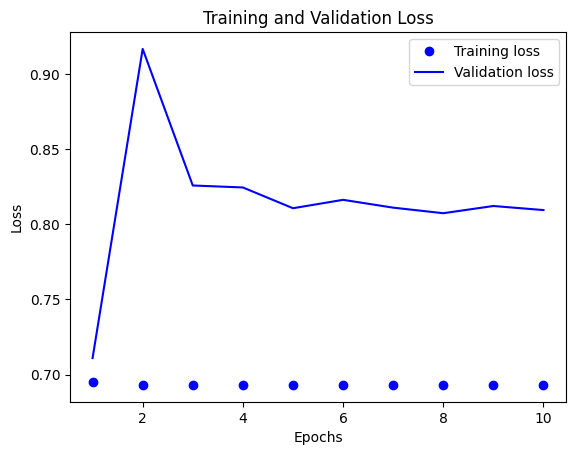

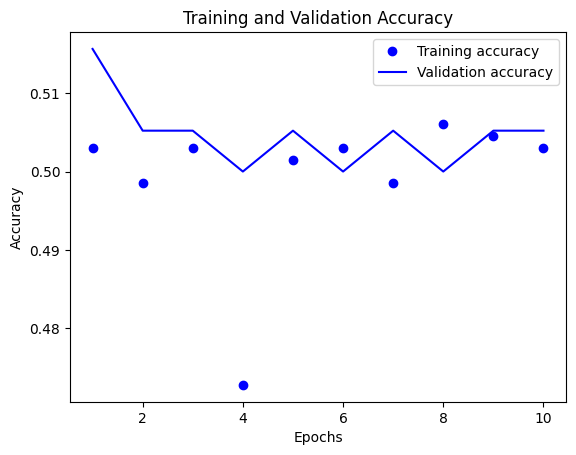

In [69]:
# Learning graph
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It's possible to have higher validation accuracy than training accuracy when using data augmentation techniques such as adding noise.

## Basic augumentation

In [70]:
# Read the data
train_set_b = train_datagen.flow_from_directory(
    train_path,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical'
)

test_set_b = test_datagen.flow_from_directory(
    test_path,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [71]:
# Model with RGB colors
input_shape = (64, 64, 3)

# Model building
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Model fitting
history = model.fit(
    train_set_b,
    steps_per_epoch=train_set_b.samples//batch_size,
    epochs=epochs,
    validation_data=test_set_b,
    validation_steps=test_set_b.samples//batch_size
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 12544)             0         
                                                                 
 dropout_8 (Dropout)         (None, 12544)            

TypeError: ignored

In [ ]:
# Learning graph
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Transfer learning + best augumentation

In [72]:
# Set input shape and number of classes
input_shape = (64, 64, 3)
num_classes = 2

# Create a ResNet50 model with pre-trained weights
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the pre-trained model
for layer in resnet50.layers:
    layer.trainable = False

# Add new classification layers on top of the pre-trained model
x = Flatten()(resnet50.output)
x = Dense(512, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

# Create a new model
model = tf.keras.Model(inputs=resnet50.input, outputs=x)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/10
22/22 [==============================] - 25s 888ms/step - loss: 0.8404 - accuracy: 0.5288 - val_loss: 0.6893 - val_accuracy: 0.5050
Epoch 2/10
22/22 [==============================] - 18s 827ms/step - loss: 0.6714 - accuracy: 0.5850 - val_loss: 0.6105 - val_accuracy: 0.6700
Epoch 3/10
22/22 [==============================] - 19s 838ms/step - loss: 0.6234 - accuracy: 0.6412 - val_loss: 0.6254 - val_accuracy: 0.5950
Epoch 4/10
22/22 [==============================] - 20s 914ms/step - loss: 0.6741 - accuracy: 0.6095 - val_loss: 0.5965 - val_accuracy: 0.6750
Epoch 5/10
22/22 [==============================] - 20s 926ms/step - loss: 0.6248 - accuracy: 0.6427 - val_loss: 0.5795 - val_accuracy: 0.7200
Epoch 6/10
22/22 [==============================] - 19s 872ms/step - loss: 0.6076 - accuracy: 0.6628 - val_loss: 0.5876 - val_accuracy: 0.6850
Epoch 7/10
22/22 [==============================] - 19s 862ms/step - loss: 0.6104 - accuracy: 0.6643 - val_loss: 0.5933 - val_accuracy: 0.6900

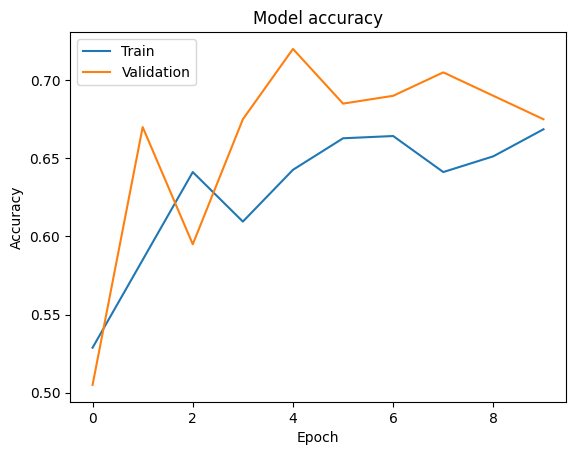

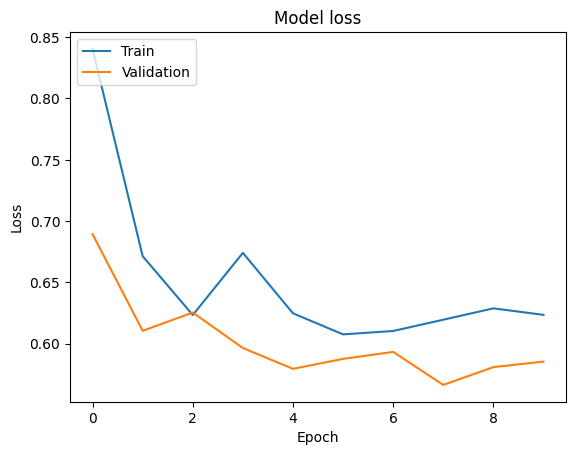

In [73]:
# Train the model
history = model.fit(train_set_b, epochs=10, validation_data = test_set_b)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_set_b)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Gradio

In [77]:
# Class names
class_names = ['alien', 'predator']


def predict_image(img):
    # Load image and preprocess
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)

    # Get predictions and heatmap
    predictions = model.predict(x)
    predicted_class = np.argmax(predictions)
    heatmap = visualize_cam(model, layer_idx=-1, filter_indices=predicted_class, seed_input=x[0], backprop_modifier=None)

    # Resize heatmap and blend with original image
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    # Return predicted class and heatmap
    return class_names[predicted_class], blended


# Create interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.inputs.Image(type='numpy', label='Input image (jpg or png)'),
    outputs=['label', gr.outputs.Image(type='numpy', label='Blended heatmap')]
)

# Launch interface
iface.launch()


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>